**Please download the dataset at this**: [link](https://drive.google.com/drive/folders/1knZGVI_WzuJ9E63vlnBKIB2UgZPdVDzc?usp=sharing)

In [20]:
import torch
import numpy as np
import pandas as pd
import os
from torch_geometric.data import Data, InMemoryDataset
from torch_geometric.loader import DataLoader
from shutil import copyfile
from dataclasses import dataclass
from torch_geometric import utils
import networkx as nx
from pyvis.network import Network
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import time

In [21]:
def distance_to_weight(W, sigma2=0.1, epsilon=0.5, gat_version=False):
    n = W.shape[0]
    W = W / 10000.
    W2, W_mask = W * W, np.ones([n,n]) - np.identity(n)

    W = np.exp(-W2 / sigma2) * (np.exp(-W2 / sigma2) >= epsilon) * W_mask
    if gat_version:
        W[W>0] = 1
        W += np.identity(n)

    return W

In [22]:
def z_score(x, mean, std):
    return (x - mean) / std

def un_z_score(x_normed, mean, std):
    return x_normed * std + mean

def MAPE(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred) / (y_true + 1e-15) * 100)

def RMSE(y_true, y_pred):
    return torch.sqrt(torch.mean((y_true - y_pred)**2))

def MAE(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

In [23]:
class TrafficDataset(InMemoryDataset):
    def __init__(self, config, W, root='', transform=None, pre_transform=None):
        self.config = config
        self.W = W
        super().__init__(root, transform, pre_transform)
        self.data, self.slices, self.n_node, self.mean, self.std = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [os.path.join(self.raw_dir, "PeMSD7_V_228.csv")]

    @property
    def processed_file_names(self):
        return ["./data.pt"]

    def download(self):
        copyfile("PeMSD7_V_228.csv", os.path.join(self.raw_dir, "PeMSD7_V_228.csv"))

    def process(self):
        data = pd.read_csv(self.raw_file_names[0], header=None).values
        mean = np.mean(data)
        std = np.std(data)
        data = z_score(data, mean, std)

        n_node = data.shape[1]
        n_window = self.config.N_PRED + self.config.N_HIST

        edge_index = torch.zeros((2, n_node**2), dtype=torch.long)
        edge_attr = torch.zeros((n_node**2, 1))

        num_edges = 0
        for i in range(n_node):
            for j in range(n_node):
                if self.W[i, j] != 0.:
                    edge_index[0, num_edges] = i
                    edge_index[1, num_edges] = j
                    edge_attr[num_edges] = W[i, j]
                    num_edges += 1

        edge_index = edge_index.resize_(2, num_edges)
        edge_attr = edge_attr.resize_(num_edges, 1)

        sequences = []
        for i in range(self.config.N_DAYS):
            for j in range(self.config.N_SLOTS):
                g = Data()
                g.__num_nodes__ = n_node

                g.edge_index = edge_index
                g.edge_attr = edge_attr

                start = i * self.config.N_DAYS_SLOT + j
                end = start + n_window

                full_window = data[start:end, :].T
                g.x = torch.tensor(full_window[:, :self.config.N_HIST], dtype=torch.float)
                g.y = torch.tensor(full_window[:, self.config.N_HIST:], dtype=torch.float)
                sequences += [g]

        data, slices = self.collate(sequences)
        torch.save((data, slices, n_node, mean, std), self.processed_paths[0])

    def get_splits(dataset, n_slots, splits):
        split_train, split_val, _ = splits
        i = n_slots*split_train
        j = n_slots*split_val
        train = dataset[:i]
        val = dataset[i:i+j]
        test = dataset[i+j:]

        return train, val, test

In [24]:
@dataclass
class Config:
    BATCH_SIZE = 50
    EPOCHS = 60
    WEIGHT_DECAY = 5e-5
    INITIAL_LR = 3e-4
    CHECKPOINT_DIR = './runs'
    N_PRED = 9
    N_HIST = 12
    DROPOUT = 0.2
    N_DAYS_SLOT = 288
    N_DAYS = 44
    USE_GAT_WEIGHTS = True
    N_NODE = 228
    N_SLOTS = N_DAYS_SLOT - (N_PRED + N_HIST)

config = Config()

In [25]:
distances = pd.read_csv("PeMSD7_W_228.csv", header=None).values
W = distance_to_weight(distances, gat_version=config.USE_GAT_WEIGHTS)
dataset = TrafficDataset(config, W)

Processing...
Done!


In [26]:
ng = utils.to_networkx(dataset[1])
pg = Network(height="750px", width="100%", bgcolor="#222222", font_color="white", notebook=True)
pg.from_nx(ng)

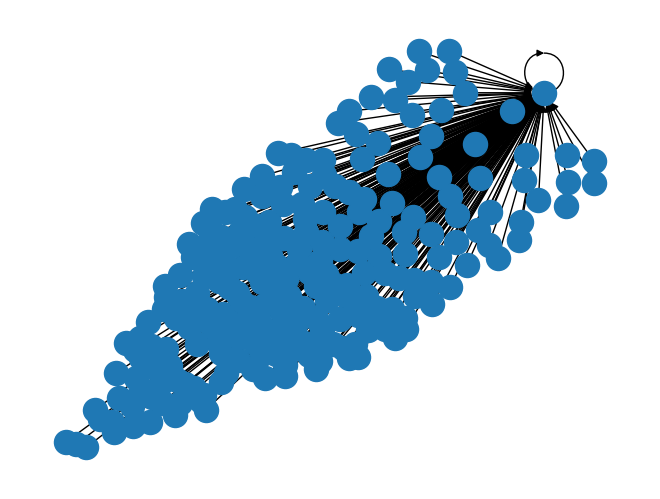

In [27]:
nx.draw(ng)

In [28]:
pg.show("example.html")

example.html


In [29]:
class ST_GAT(torch.nn.Module):
    def __init__(self, input_dim, output_dim, n_nodes, heads=8, dropout=0.0):
        super(ST_GAT, self).__init__()
        self.n_pred = output_dim
        self.heads = heads
        self.dropout = dropout
        self.n_nodes = n_nodes

        self.n_preds = 9
        lstm1_hidden_size = 32
        lstm2_hidden_size = 128

        self.gat = GATConv(input_dim, input_dim, heads=heads, dropout=0, concat=False)

        self.lstm1 = torch.nn.LSTM(n_nodes, hidden_size=lstm1_hidden_size, num_layers=1)
        for name, param in self.lstm1.named_parameters():
            if "bias" in name:
                torch.nn.init.constant_(param, 0.0)
            elif "weight" in self.lstm1.named_parameters():
                torch.nn.init.xavier_uniform_(param)

        self.lstm2 = torch.nn.LSTM(lstm1_hidden_size, hidden_size=lstm2_hidden_size, num_layers=1)
        for name, param in self.lstm2.named_parameters():
            if "bias" in name:
                torch.nn.init.constant_(param, 0.0)
            elif "weight" in self.lstm2.named_parameters():
                torch.nn.init.xavier_uniform_(param)

        self.linear = torch.nn.Linear(lstm2_hidden_size, n_nodes*self.n_pred)
        torch.nn.init.xavier_uniform_(self.linear.weight)

    def forward(self, data, device):
        x, edge_index = data.x, data.edge_index

        if device == "cpu":
            x = torch.FloatTensor(x)
        else:
            x = torch.cuda.FloatTensor(x)

        x = self.gat(x, edge_index)
        x = F.dropout(x, p=self.dropout, training=self.training)

        batch_size = data.num_graphs
        n_nodes = int(data.num_nodes / batch_size)
        x = torch.reshape(x, (batch_size, n_nodes, data.num_features))

        x = torch.movedim(x, 2, 0)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        x = torch.squeeze(x[-1, :, :])
        x = self.linear(x)

        s = x.shape
        x = torch.reshape(x, (s[0], self.n_nodes, self.n_pred))
        x = torch.reshape(x, (s[0]*self.n_nodes, self.n_pred))

        return x

In [30]:
@torch.no_grad()
def eval(model, device, dataloader, type=''):
    model.eval()
    model.to(device)

    mae = rmse = mape = n = 0
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        if batch.x.shape[0] == 1:
            pass
        else:
            with torch.no_grad():
                pred = model(batch, device)
            truth = batch.y.view(pred.shape)
            if i == 0:
                y_pred = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])
                y_truth = torch.zeros(len(dataloader), pred.shape[0], pred.shape[1])

            truth = un_z_score(truth, dataloader.dataset.mean, dataloader.dataset.std)
            pred = un_z_score(pred, dataloader.dataset.mean, dataloader.dataset.std)

            y_pred[i, :pred.shape[0], :] = pred
            y_truth[i, :pred.shape[0], :] = truth

            rmse += RMSE(truth, pred)
            mae += MAE(truth, pred)
            mape += MAPE(truth, pred)
            n += 1
    rmse, mae, mape = rmse/n, mae/n, mape/n
    print(f"{type}, MAE : {mae}, RMSE : {rmse}, MAPE : {mape}")

    return rmse, mae, mape, y_pred, y_truth

In [31]:
def train(model, device, dataloader, optimizer, loss_fn, epoch):
    model.train()
    for _, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch}")):
        batch = batch.to(device)
        optimizer.zero_grad()
        y_pred = torch.squeeze(model(batch, device))
        loss = loss_fn(y_pred.float(), torch.squeeze(batch.y).float())
        writer.add_scalar("Loss / Train", loss, epoch)
        loss.backward()
        optimizer.step()

    return loss

In [32]:
def model_train(train_dataloader, val_dataloader, config, device):
    model = ST_GAT(input_dim=config.N_HIST, output_dim=config.N_PRED, n_nodes=config.N_NODE, dropout=config.DROPOUT)
    optimizer = torch.optim.Adam(model.parameters(), lr=config.INITIAL_LR, weight_decay=config.WEIGHT_DECAY)
    loss_fn = torch.nn.MSELoss()

    model.to(device)

    for epoch in range(config.EPOCHS):
        loss = train(model, device, train_dataloader, optimizer, loss_fn, epoch)
        print(f"Loss: {loss:.3f}")
        if epoch % 5 == 0:
            train_mae, train_rmse, train_mape, _, _ = eval(model, device, train_dataloader, "Train")
            val_mae, val_rmse, val_mape, _, _ = eval(model, device, val_dataloader, "Valid")
            writer.add_scalar(f"MAE/train", train_mae, epoch)
            writer.add_scalar(f"RMSE/train", train_rmse, epoch)
            writer.add_scalar(f"MAPE/train", train_mape, epoch)
            writer.add_scalar(f"MAE/val", val_mae, epoch)
            writer.add_scalar(f"RMSE/val", val_rmse, epoch)
            writer.add_scalar(f"MAPE/val", val_mape, epoch)

    writer.flush()
    timestr = time.strftime("%m-%d-%H%M%S")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "opimizer_state_dict": optimizer.state_dict(),
        "loss": loss
    }, os.path.join(config.CHECKPOINT_DIR, f"model_{timestr}.pt"))

    return model

In [33]:
def model_test(model, test_dataloader, device, config):
    _, _, _, y_pred, y_truth = eval(model, device, test_dataloader, "Test")

In [34]:
d_train, d_val, d_test = dataset.get_splits(config.N_SLOTS, (34, 5, 5))
train_dataloader = DataLoader(d_train, batch_size=config.BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(d_val, batch_size=config.BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(d_test, batch_size=config.BATCH_SIZE, shuffle=False)

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cpu


In [36]:
config.N_NODE = dataset.n_node

In [37]:
writer = SummaryWriter()

In [38]:
model = model_train(train_dataloader, val_dataloader, config, device)

Epoch 0: 100%|████████████████████████████████████████████████████████████████████████| 182/182 [01:46<00:00,  1.70it/s]


Loss: 0.395
Train, MAE : 4.800570011138916, RMSE : 7.7068562507629395, MAPE : 12.819315910339355
Valid, MAE : 4.856338024139404, RMSE : 7.659911155700684, MAPE : 13.054655075073242


Epoch 1: 100%|████████████████████████████████████████████████████████████████████████| 182/182 [00:26<00:00,  6.77it/s]


Loss: 0.243


Epoch 2: 100%|████████████████████████████████████████████████████████████████████████| 182/182 [00:29<00:00,  6.07it/s]


Loss: 0.242


Epoch 3: 100%|████████████████████████████████████████████████████████████████████████| 182/182 [01:47<00:00,  1.70it/s]


Loss: 0.199


Epoch 4:  29%|█████████████████████▎                                                   | 53/182 [00:17<00:42,  3.05it/s]


KeyboardInterrupt: 